# Price a European Up-and-out Call Option

Group 6-A

Members:

Md. Shafil Hosain (shafil430@yahoo.com)

Si Jie Lim (limsijie93@gmail.com)

Quang Vinh Dang (dqvinh87@gmail.com)

Wei Hao Lew (lewweihao93@hotmail.com)

Philip ZF Chen (philipchen619@gmail.com)

In this report, we are going to price an Up-And-Out barrier call option using Monte Carlo simuation. An Up-And-Out barrier call option is just like a normal call option, except that once the underlying reaches above a certain barrier level at any point in time, it will expire worthless. Otherwise, it expires like a normal call. Hence, it is path-dependent.

## Import libraries

Firstly, we import all the libraries that are needed for this project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm
from tqdm import tqdm
import functools 

To simulate paths for the underlying share and firm's value, we first need to define a function to output the path given a starting value, the interest rate r, the volatility sigma, a series of standard normal variables Z and the step time dT. This step time is needed as we want to keep track of the value of the share at each point in time, so that we know if it has exceeded the barrier limit of the barrier option.

## Define functions 

In [2]:
def share_path(S_0, r, sigma, Z, dT):
    return S_0 * np.exp(np.cumsum((r - sigma**2/2) * dT + sigma * np.sqrt(dT) * Z))

This is based on the assumption that the share/firm value evolves according to the following lognormal distribution

$S_T = S_0 exp((r-\frac{\sigma^2}{2})T + \sigma\sqrt{T}Z)$

which is a solution of the following stochastic differential equation

$dS_t = rS_tdt + \sigma S_tdW_t $

Here, the equation can be written in the form of a cumulative sum as

$S_t = S_0 exp(\sum_{i=1}^{t}((r-\frac{\sigma^2}{2})dT + \sigma\sqrt{dT}Z_i))$

where dT is the timestep while each $Z_i$ is an independently generated standard normal random variable. For this exercise, we are letting the timestep be 1/12 since we are doing monthly simulations for a year.

In [3]:
def european_call_payoff(S_T, K, r, T):
    """
    This function takes in the following parameters to determine the price of the European call option:
      S_T is the price of the underlying at expiry.
      K is the strike price
      r is the risk free rate
      T is the time period till maturity. This can be in months or years depending on the user's preference. In our case, it is in year.

    The value of the European call option is determined by taking the discounted value of the final call option payoff
    using the formula: np.exp(-T*r) * np.maximum(0, S_T - K)
    """
    return np.exp(-T*r) * np.maximum(0, S_T - K) #payoff for call option

def euro_uao_call(barrier, paths, K, r, T):
    """
    This functions takes in the following parameters to calculate the value of a European Up-And-Out call option:
      barrier is the barrier level,
      paths is a list of share price paths,
      K is the strike price
      r is the risk free rate
      T is the time period of each share price path.
    """
    prices = []
    for path in paths:
            if np.max(path) > barrier: # knocked out
                    prices.append(0)
            else:
                    prices.append(european_call_payoff(path[-1], K, r, T)) 
    return np.mean(prices)

To price the European Up-And-Out call option, we use the payoff stated in the question:

- v($S_t$) = ($S_t$ - K)$^+$ given max(S - t < L) for t between [0, T] where K is the strike of the option, L is the barrier level, and $S_t$ is the share price at time t.

We then discount the payoff by the duration of the option T. As this is a barrier option, the option expires worthless if at any point in time in the path the price reaches above the barrier. Otherwise, the payoff defaults to a normal European call. This is iterated over multiple times to get the expected value, which is the mean.

## Defining parameters

Next, we define the values of the parameters needed. We shall assume that the firm's value starts at the same value as the underlying share, at 100.

In [4]:
T = 1                   #expiry time of option
L = 150                 #barrier limit
S_0 = 100               #starting share value
K = 100                 #strike price
V_0 = 100               #starting firm value
r = 0.08                #interest rate
sigma_s = 0.30          #share volatility
sigma_v = 0.25          #firm value volatility
debt = 175              #firm debt
correlation = 0.2       #correlation between share and firm
recovery_rate = 0.25    #firm recovery rate
frequency = 12          #monthly simulations for a year

From the correlation value, we can build a correlation matrix

In [5]:
corr_matrix = np.array([[1, correlation], [correlation, 1]])

## 1. Simulate paths for the underlying share and for the counterparty’s firm value using sample sizes of 1000, 2000, …, 50000. Do monthly simulations for the lifetime of the option.

Next, we will begin simulating the paths with a for loop.

100%|██████████| 50/50 [02:23<00:00,  2.86s/it]


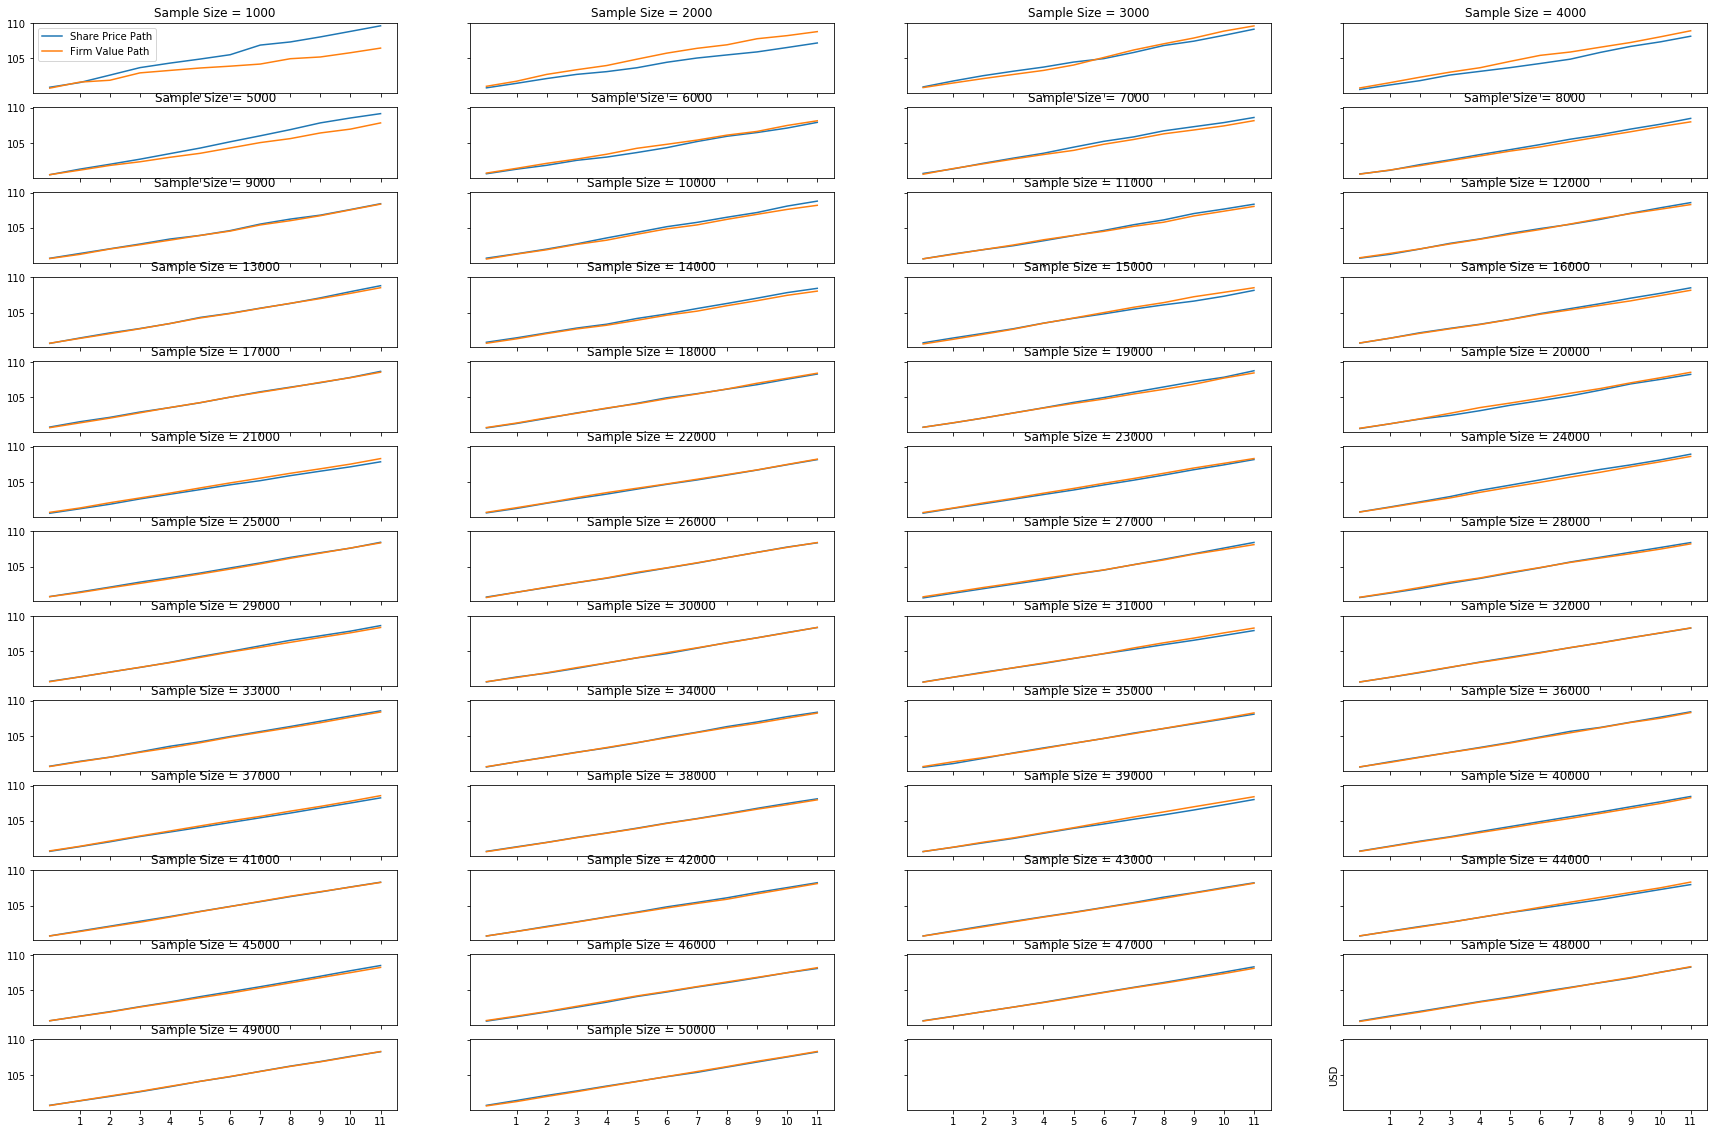

In [6]:
######### This is for figure plotting ###########
plt.rcParams["figure.figsize"] = (30,20)
fig, ax = plt.subplots(13,4, sharex=True, sharey=True)
plt.xticks (range (1,13))
plt.ylabel ('USD')
#################################################

################################################
#######      Monte Carlo Simulation    #########
################################################

for sampleSize in tqdm(range(1000, 51000, 1000)):    
    share_path_list = []
    firm_value_list = []
    
    #for each sample size, sum up all price path for each simulation so that the mean can be calculated later
    for i in range(0, sampleSize):
        norm_matrix = norm.rvs(size=np.array([2, frequency]))
        corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
        
        share_price_path = share_path(S_0, r, sigma_s, corr_norm_matrix[0,], T/frequency)
        firm_value_path = share_path(V_0, r, sigma_v, corr_norm_matrix[1,], T/frequency)
        share_path_list.append(share_price_path)
        firm_value_list.append(firm_value_path)
        
    share_path_mean = list(map(lambda summed: summed/sampleSize,  functools.reduce(lambda a,b: [x + y for x, y in zip(a, b)], share_path_list)))
    firm_value_mean = list(map(lambda summed: summed/sampleSize,  functools.reduce(lambda a,b: [x + y for x, y in zip(a, b)], firm_value_list)))
    
    row_id = int ((sampleSize / 1000) / 4)
    col_id = int ((sampleSize/1000) % 4 - 1)
    if col_id == -1:
        col_id = 3
        row_id -= 1
    ax [row_id, col_id].title.set_text ('Sample Size = ' + str(sampleSize))
    ax [row_id, col_id].plot (share_path_mean, label = 'Share Price Path')
    ax [row_id, col_id].plot (firm_value_mean, label = 'Firm Value Path')
    if row_id == 0 and col_id == 0:
        ax [row_id, col_id].legend()

- We will loop through each sample size starting with 1000, in increments of 1000, until the largest sample size of 50000. 

- We also create 2 new lists, share_path_list and firm_value_list, to keep track of the path for each simulation. For each sample size, we will generate a 2x12 matrix of uncorrelated standard normal random variables into norm_matrix. The 2 rows are needed, 1 for share price and the other for firm value. The 12 columns correspond to each month of the simulation for the entire year. 

- To turn this into correlated matrix, we then do a Cholesky decomposition of the correlation matrix built earlier, multiplied with norm_matrix, to give corr_norm_matrix, which gives a matrix of correlated random variables. 

- The first row of the matrix is the random variables for share price, while the second row is for the firm value. By passing these random variables into the share_path function, we generate the path and save them into the respective lists.

- We also computed the mean path for each sample size by adding up all the paths and then dividing by the sample size itself. After plotting what the mean path looks like for each sample size, we notice that the larger the sample size, the closer the resemblance of the share price and the firm value.

- For visualisation purposes, we can also pick a random path from the list and plot it.

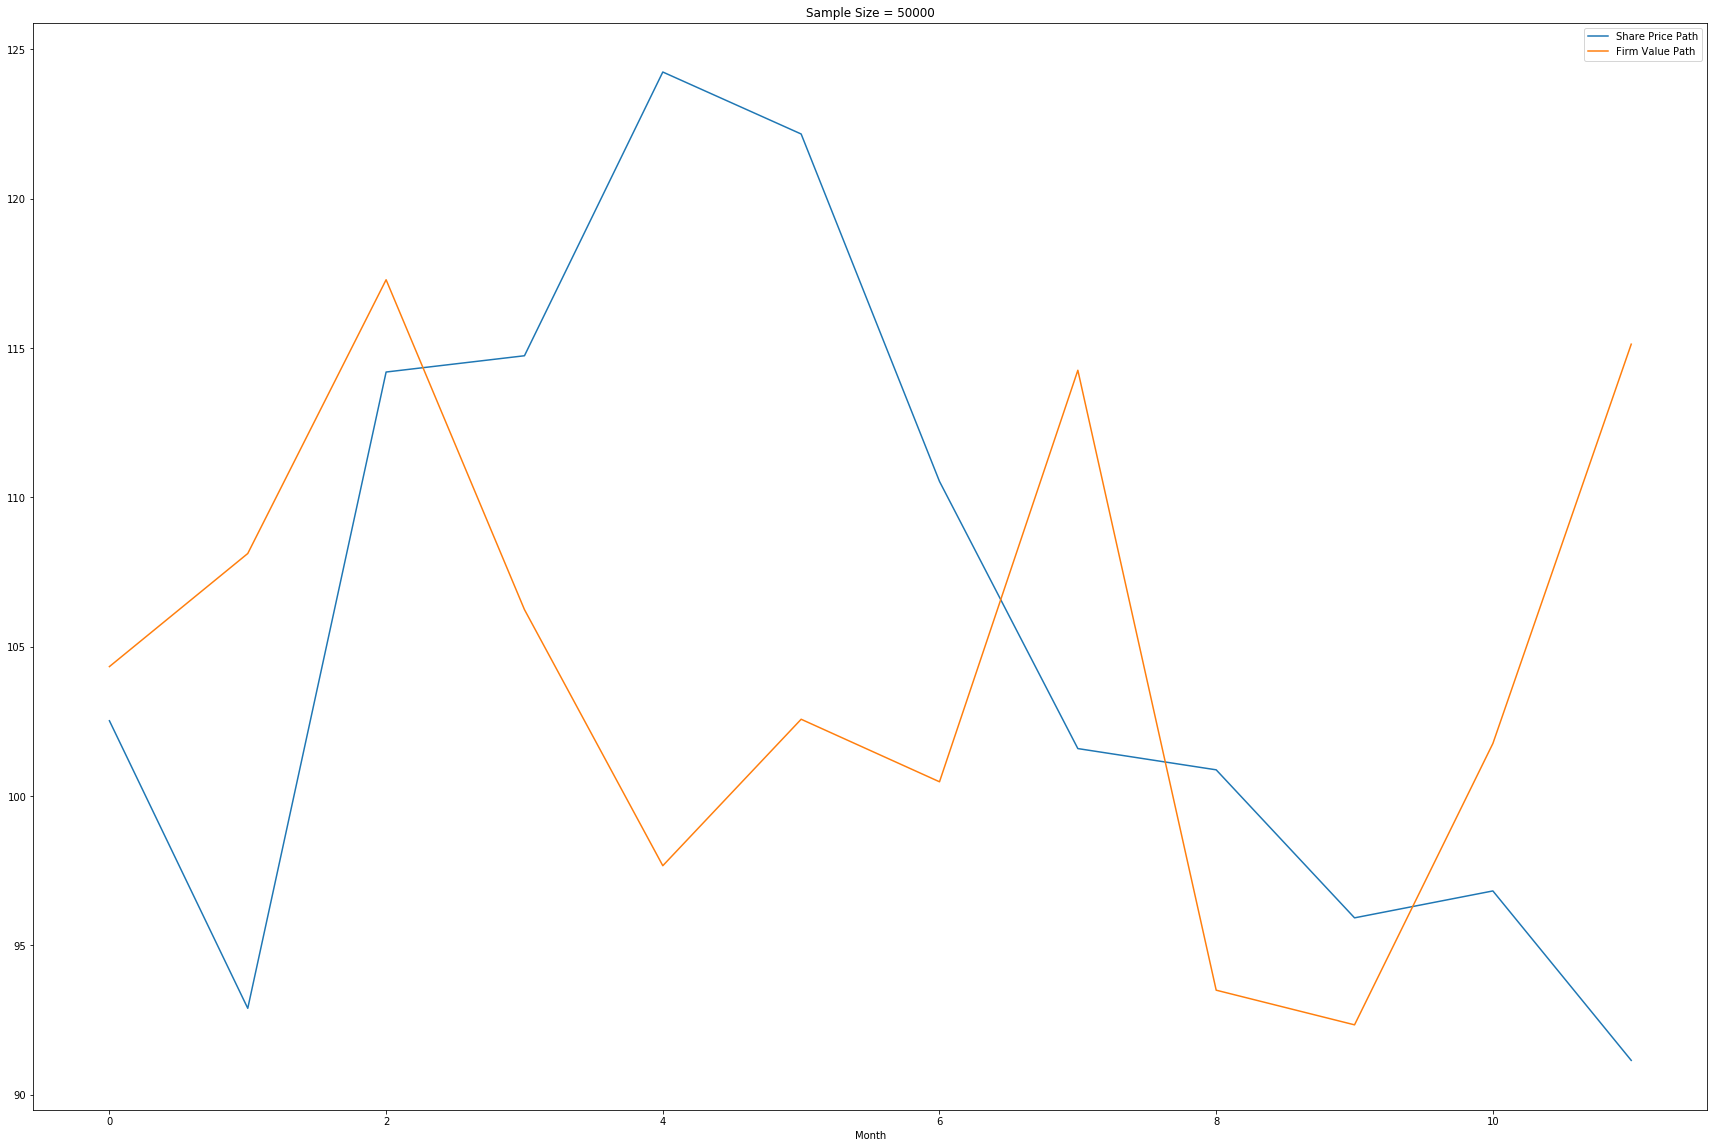

In [7]:
plt.title ('Sample Size = ' + str(sampleSize))
plt.plot (share_path_list[0], label = 'Share Price Path')
plt.plot (firm_value_list[0], label = 'Firm Value Path')
plt.xlabel ('Month')    
plt.legend()
plt.show()

## 2. Determine Monte Carlo estimates of both the default-free value of the option and the Credit Valuation Adjustment (CVA).
## 3. Calculate the Monte Carlo estimates for counterparty risk

To determine the Monte Carlo estimates of the option and CVA, we will need to use the simulation results from question 1. To make improve user readability, we will copy over the code from question 1 and add in the CVA and option value (from line 23 onwards).

100%|██████████| 50/50 [02:44<00:00,  3.29s/it]


Sample Size	Default Option Price	CVA			Adjusted Option Price
1000		6.7408085628538705	4.916552172876764	1.8242563899771067
2000		6.788248985806658	4.9309244213881245	1.8573245644185334
3000		6.568411665942631	4.810385131115086	1.758026534827545
4000		6.452785904380344	4.698063710250646	1.7547221941296982
5000		6.852116882868053	4.9773175006669215	1.8747993822011315
6000		6.76999565243806	4.927752879091902	1.8422427733461575
7000		6.6991481755482	4.903278203284726	1.795869972263474
8000		6.906954494476742	5.056387754120078	1.8505667403566637
9000		6.668683842530434	4.873331002831551	1.7953528396988823
10000		6.694961086156899	4.88610505449867	1.8088560316582285
11000		6.609351185458687	4.815299217332226	1.7940519681264604
12000		6.792697054382697	4.949337476118712	1.8433595782639847
13000		6.770339762889736	4.955163435239791	1.8151763276499455
14000		6.668660833340556	4.862865063186234	1.8057957701543215
15000		6.752446704176719	4.9196746348242435	1.8327720693524752
16000		6.67637773541

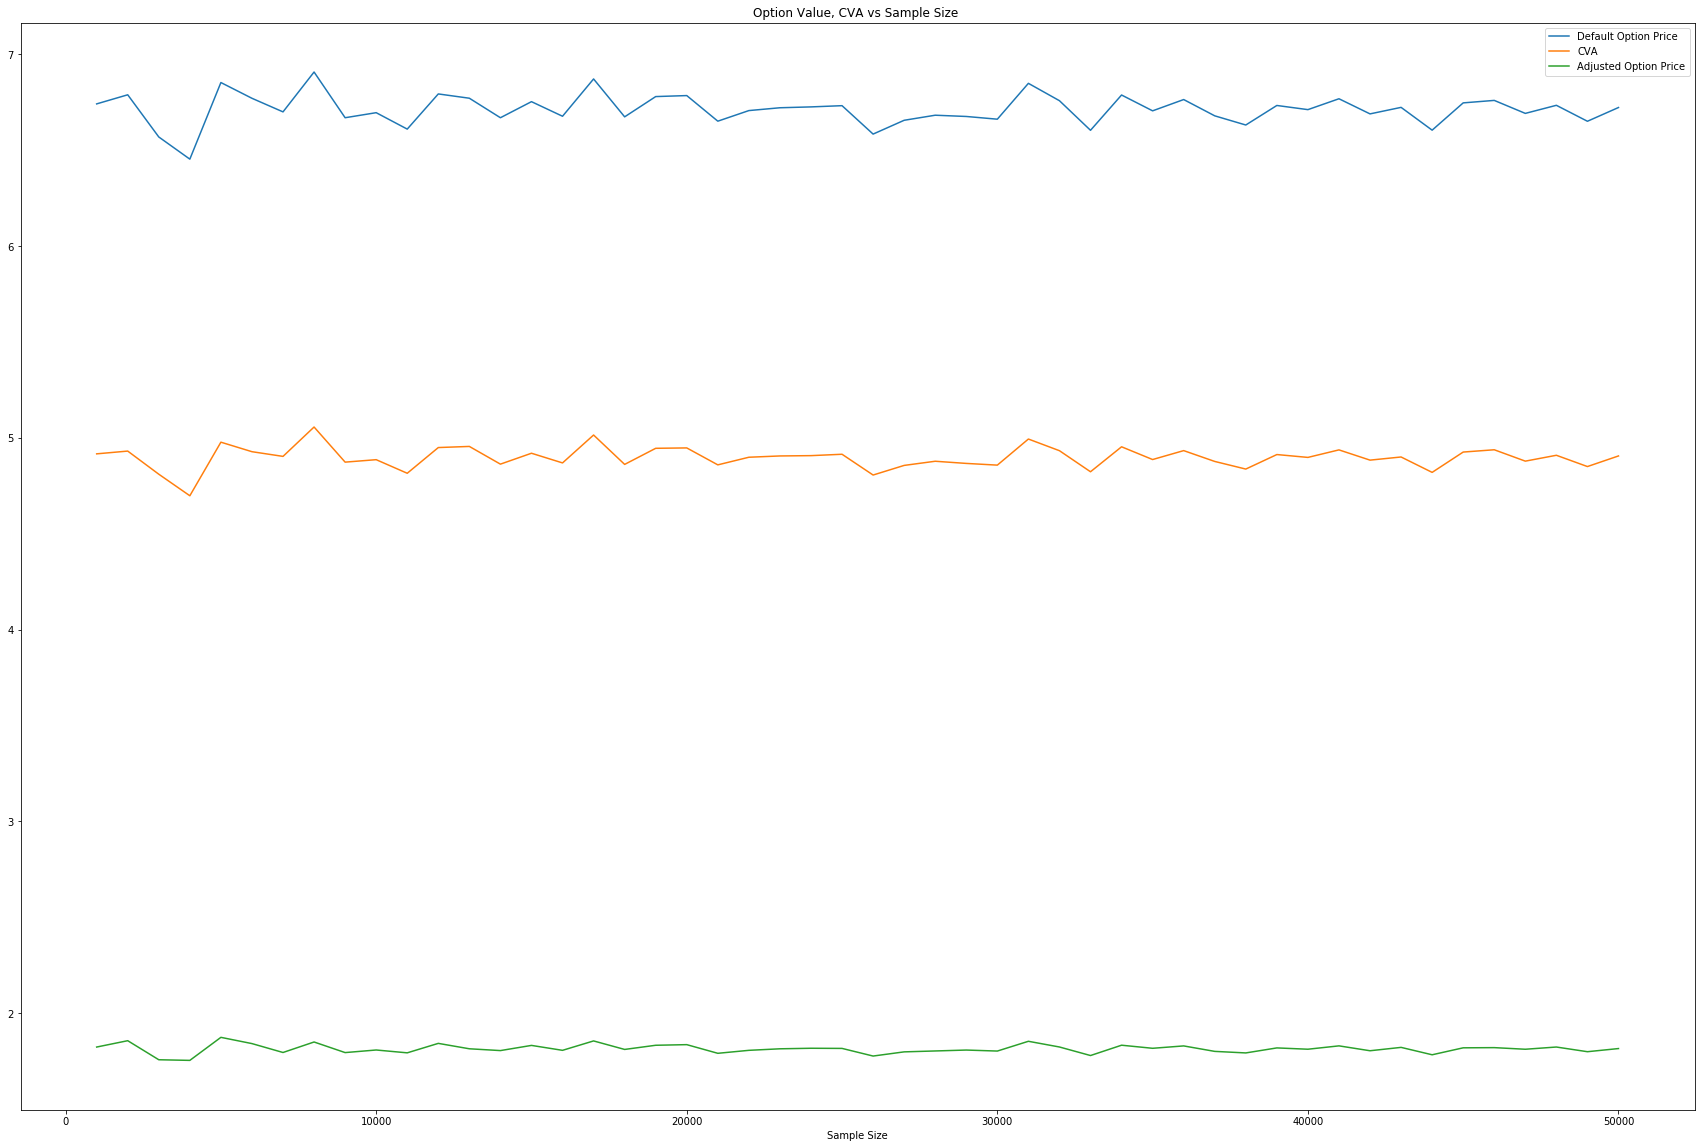

In [8]:
#2. Determine Monte Carlo estimates of both the default-free value of the option and the Credit Valuation Adjustment (CVA).
#3. Calculate the Monte Carlo estimates for the price of the option incorporating counterparty risk, given by the default-free price less the CVA.
call_val_list = []
cva_list = []
adjusted_call_list = []

for sampleSize in tqdm(range(1000, 51000, 1000)):
    share_path_list = []
    firm_value_list = []
    
    #for each sample size, sum up all price path for each simulation so that the mean can be calculated later
    for i in range(0, sampleSize):
        norm_matrix = norm.rvs(size=np.array([2, frequency]))
        corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
        share_price_path = share_path(S_0, r, sigma_s, corr_norm_matrix[0,], T/frequency)
        firm_value_path = share_path(V_0, r, sigma_v, corr_norm_matrix[1,], T/frequency)
        share_path_list.append(share_price_path)
        firm_value_list.append(firm_value_path)

    #get the mean path for the sum of all the simulations
    share_path_mean = list(map(lambda summed: summed/sampleSize,  functools.reduce(lambda a,b: [x + y for x, y in zip(a, b)], share_path_list)))
    firm_value_mean = list(map(lambda summed: summed/sampleSize,  functools.reduce(lambda a,b: [x + y for x, y in zip(a, b)], firm_value_list)))

    """Note that the code above is the same as question 1"""

    ################################################
    #######     terminal value of option   #########
    ################################################
    #print(share_path_list)
    call_val = euro_uao_call(L, share_path_list, K, r, T) # obtain the Up-and-out European call option value using the defined function euro_uao_call
    # Extract the terminal firm values
    term_firm_values = list(map(lambda x: x[-1], firm_value_list))
    
    # Note: the explanation of the functions are defined above under the "Define functions" section

    ################################################
    #######               CVA              #########
    ################################################

    # To calculate the amount lost, we apply the formula [np.exp(-T/frequency*r) * (1-recovery_rate)*(term_firm_val < debt) * call_val]
    # for each simulated terminal firm value in the monte carlo simulation. 
    amount_lost = [np.exp(-T/frequency*r) * (1-recovery_rate)*(term_firm_val < debt) * call_val for term_firm_val in term_firm_values] # calculate the amount lost
    cva = np.mean(amount_lost)
    adjusted_opt_val = call_val - cva
    
    call_val_list.append(call_val)
    cva_list.append(cva)
    adjusted_call_list.append(adjusted_opt_val)
        
print("Sample Size\tDefault Option Price\tCVA\t\t\tAdjusted Option Price")
for sampleSize, call, cva, adj in zip(range(1000, 51000, 1000), call_val_list, cva_list, adjusted_call_list):
    print(str(sampleSize)+"\t\t"+str(call)+"\t"+str(cva)+"\t"+str(adj))   
        
xi = [i for i in range(1000, 51000, 1000)]   
    
plt.title ('Option Value, CVA vs Sample Size ')
plt.plot (xi, call_val_list, label = 'Default Option Price')
plt.plot (xi, cva_list, label = 'CVA')
plt.plot (xi, adjusted_call_list, label = 'Adjusted Option Price')
plt.xlabel ('Sample Size')    
plt.legend()
plt.show()

After calling the appropriate function euro_uao_call to get the default call option value, we can use it along together with the list of terminal firm values, to get a list of amount_lost, the mean of which would be the CVA. The list of terminal values is formed by extracting the last element of each list. Then, this CVA is subtracted from the default call option value to get the adjusted vall option value.

By taking the largest sample size of 50000, the default price of the option is 6.78, CVA is 4.95 and the adjusted option price is 1.84. The plot of the 3 different values against sample size is shown in the diagram above. We can see that as the sample size increases, the line flattens out as the value stabilises with more simulations.

## Blibiography

Chen, J. (2019, April 14). Barrier Option Definition. Retrieved from https://www.investopedia.com/terms/b/barrieroption.asp.

Palisade. (n.d.). What is Monte Carlo Simulation? Retrieved from http://www.palisade.com/risk/monte_carlo_simulation.asp.

Levy, G. (2003). Computational finance. Oxford: Butterworth-Heinemann.